In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import re
import numpy

import matplotlib.pyplot as plt

In [4]:
# From http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

In [5]:
tf.reset_default_graph()

In [6]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 100))
                                               
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 100))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 100))

Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
print("The streams return batches containing %s" % (mnist_train_stream.sources,))

print("Each trainin batch consits of a tuple containing:")
for element in next(mnist_train_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))
    
print("Validation/test batches consits of tuples containing:")
for element in next(mnist_test_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (100, 1, 28, 28) containing float32
 - an array of size (100, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 1, 28, 28) containing float32
 - an array of size (100, 1) containing uint8


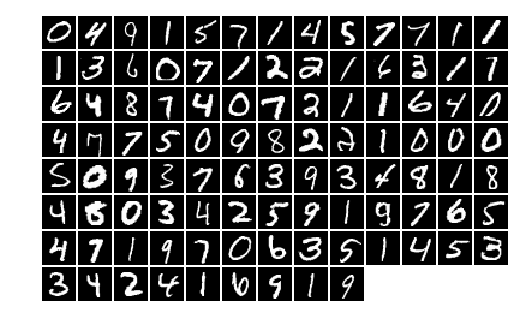

In [8]:
from common.plotting import plot_mat

mnist_X,mnist_Y= next(mnist_train_stream.get_epoch_iterator())

plot_mat(mnist_X, cmap='gray')

# SVD factorization

In [9]:
mnist_train_X = mnist_train._data_sources[0] / (255./2.) - 1.0

mnist_train_X_flat = mnist_train_X.reshape([mnist_train_X.shape[0], -1])
mnist_train_X_flat_norm = mnist_train_X_flat - mnist_train_X_flat.mean(axis=0, keepdims=True)

In [10]:
U,S,V_t = np.linalg.svd(mnist_train_X_flat_norm,
                      full_matrices=0)

In [79]:
K=198
svd_err = np.sum((mnist_train_X_flat_norm - np.dot(U[:, :K]*S[:K], V_t[:K, :]))**2)
sum_sing_vals2 = (S[K:]**2).sum()

print ("Svd err: %g, sum_sing_vals^2: %g, diff: %g" %
       (svd_err, sum_sing_vals2, svd_err-sum_sing_vals2))
print ("Mean per-pixel err: %g" %(svd_err / mnist_train_X_flat_norm.shape[0]))

Svd err: 360021, sum_sing_vals^2: 360021, diff: 4.65661e-10
Mean per-pixel err: 7.20041


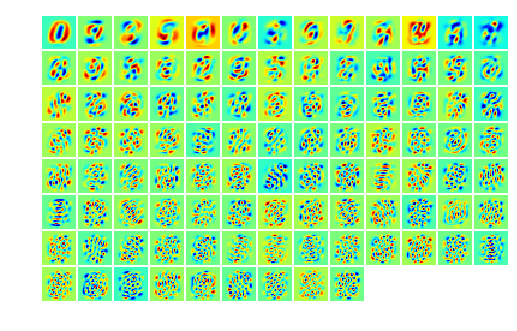

In [14]:
plot_mat(V_t[:100, :].reshape(-1, 1, 28, 28))

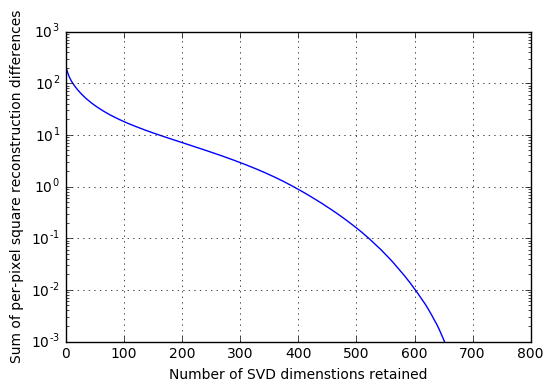

In [15]:
plt.semilogy(np.cumsum(S[::-1]**2)[::-1] / mnist_train_X_flat_norm.shape[0])
plt.grid()
plt.ylim(1e-3, 1e3)
plt.xlabel('Number of SVD dimenstions retained')
plt.ylabel('Sum of per-pixel square reconstruction differences')

# Sparse Autoencoder

In [16]:
# For this to work you must manually install spams from
# http://spams-devel.gforge.inria.fr/

import spams

We'll learn matrices $\mathbb{D}$ and $\mathbb{C}$ such that:

$$
\mathbb{D},\mathbb{C} = \text{argmin}_{\mathbb{D},\mathbb{C}} ||\mathbb{X} - \mathbb{D}\mathbb{C}||^2_2 + \lambda_1||\mathbb{C}||_1 + 0.5\lambda_2 ||\mathbb{C}||^2_2
$$

where the norm operators $||\cdot||_2$ and $||\cdot||_1$ are the first and second norm of the flattened matrices.

Mean per-pixel err: 12.5677


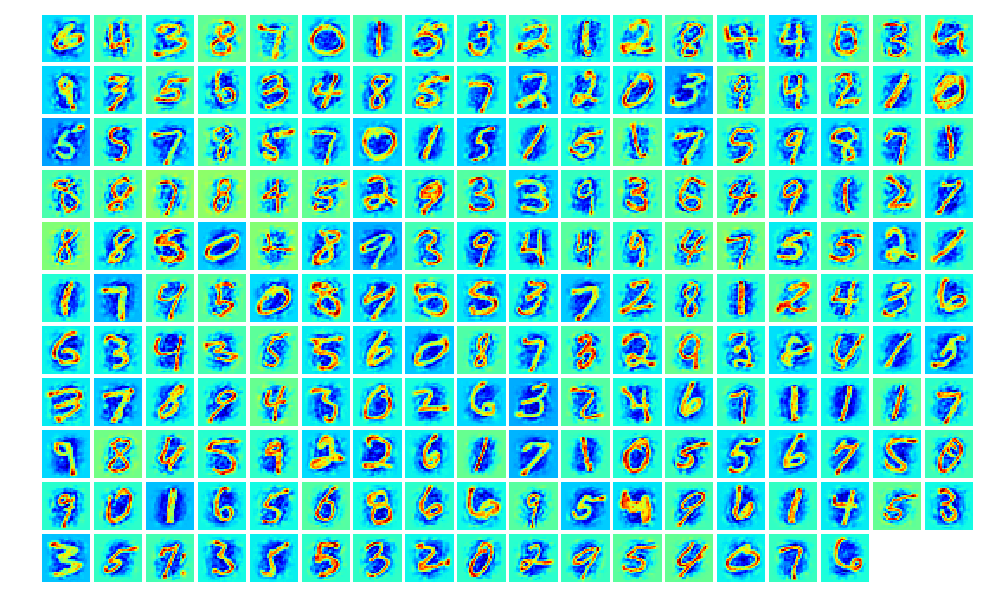

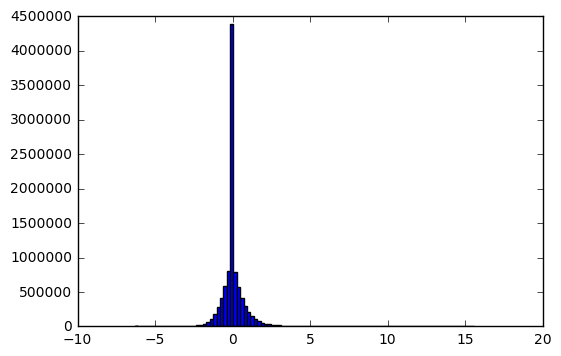

In [32]:
lambda1=0.1

D = spams.trainDL(mnist_train_X_flat_norm.T, K=196, lambda1=lambda1, )
D = D.T
C = spams.lasso(mnist_train_X_flat_norm.T, D=D.T, lambda1=lambda1)
C = np.asarray(C.T.todense())

R = C.dot(D)

print ("Mean per-pixel err: %g" %
       (np.sum((mnist_train_X_flat_norm - R)**2) / 
        mnist_train_X_flat_norm.shape[0]))

plt.figure(figsize=(12,8))
plot_mat(D.reshape(-1, 1, 28, 28))

plt.figure()
_ = plt.hist(C.ravel(), 100)

Uses of sparse coding

Consider the following figure from J Mairal (http://www.machinelearning.org/archive/icml2009/papers/364.pdf):

<img src="13-sparse-coding-inpainting.jpg">

The goal is to reconstruct the image. We can to do it by:
1. learning a dictionary for patches from natural images. Crucially, we assume that:
    - images will be easy to encode using the dictionary
    - non-images will be difficult to encode
  
  The dictionary can look like this:
  
  <img src="13-img_codebook.png">
  
2. Split the image into overlapping patches, find an encoding for all patches to properly reconstruct the known pixels
3. Use the encoding to inpaint the missing pixels!


# Neural autoencoder

In [33]:
# network building blocks

def affine_layer(X, num_hidden, activation=None, name=None):
    name = name or "affine_layer"
    with tf.variable_scope(None, default_name=name):
        W = tf.get_variable('W', (X.shape[1].value, num_hidden), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', (1, num_hidden), 'float32',
                            initializer=tf.zeros_initializer())
        Y = tf.matmul(X, W) + b
        if activation:
            Y = activation(Y)
        return Y

def conv2d_layer(X, filter_shape, num_filters, activation=None, name=None):
    name = name or "conv2d_layer"
    num_channels = X.shape[3].value
    with tf.variable_scope(None, default_name=name):
        F = tf.get_variable('F', (filter_shape[0], filter_shape[1], num_channels, num_filters), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        b = tf.get_variable('b', (1, 1, 1, num_filters), 'float32',
                            initializer=tf.zeros_initializer())
        Y = tf.nn.conv2d(X, F, (1, 1, 1, 1), padding='VALID') + b
        if activation:
            Y = activation(Y)
        return Y

In [68]:
tf.reset_default_graph()

In [69]:
# X is batch_size x num_channels x width x heigth
X = tf.placeholder(shape=(None, 1, 28, 28), dtype=np.float32, name='X')
X_NHWC = tf.transpose(X, [0, 2, 3, 1])
Y = tf.placeholder(shape=(None, 1), dtype=np.int32, name='Y')

X_flat = tf.reshape(X, (-1, np.prod(X.shape.as_list()[1:])))

In [70]:
if 0: # vanilla autoencoder, no sparsity
    num_hidden = 196
    encoder_activation = tf.nn.tanh
    sparsity_penalty = 0.
    weight_decay_l1 = {"enc": 0.0,
                       "dec": 0.0}
    weight_decay_l2 = {"enc": 1e-4,
                       "dec": 1e-4}
else:
    num_hidden = 196
    encoder_activation = tf.nn.sigmoid
    sparsity_penalty = 1e2
    desired_sparsity = 0.05
    
    weight_decay_l1 = {"enc": 0,
                       "dec": 1e-3}
    weight_decay_l2 = {"enc": 1e-4,
                       "dec": 1e-2}

# encoding part
with tf.variable_scope("enc"):
    Z = affine_layer(X_flat, num_hidden, activation=encoder_activation)

# decoding (reconstruction) part
with tf.variable_scope("dec"):
    R = affine_layer(Z, X_flat.shape[-1].value)

num_examples = tf.cast(tf.shape(R)[0], tf.float32)

# sum over pixels, mean over images
loss_rec = tf.reduce_sum(tf.square(X_flat - R)) / num_examples

if sparsity_penalty > 0:
    assert encoder_activation in [tf.nn.sigmoid]
    mean_activation = tf.reduce_mean(Z, axis=0)

    loss_sparse = sparsity_penalty * tf.reduce_sum(tf.square(desired_sparsity - mean_activation))
else:
    loss_sparse = tf.constant(0.0, dtype=tf.float32)

loss_wd_l1 = 0.0
loss_wd_l2 = 0.0
for v in tf.trainable_variables():
    if v.name.split('/')[-1].startswith('W'):
        var_weight_decay_l1 = weight_decay_l1[v.name.split('/')[0]]
        var_weight_decay_l2 = weight_decay_l2[v.name.split('/')[0]]
        
        print ("Decaying %s by l1: %g l2: %g" % 
               (v.name, var_weight_decay_l1, var_weight_decay_l2))
        loss_wd_l1 += var_weight_decay_l1 * tf.reduce_sum(tf.abs(v))
        loss_wd_l2 += var_weight_decay_l2 * tf.reduce_sum(tf.square(v))

loss = loss_rec + loss_sparse + loss_wd_l1 + loss_wd_l2

Decaying enc/affine_layer/W:0 by l1: 0 l2: 0.0001
Decaying dec/affine_layer/W:0 by l1: 0.001 l2: 0.01


In [71]:
learning_rate = tf.get_variable('learning_rate', shape=(), dtype='float32', 
                              trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
global_step = tf.get_variable('global_step', shape=(), dtype='int32', 
                              trainable=False)
train_op = tf.group(train_op, tf.assign_add(global_step, 1))
initialize_op = tf.global_variables_initializer()

In [72]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(initialize_op)

train_loss_history = []
valid_loss_history = []
epoch = 0

In [73]:
sess.run(learning_rate.assign(1e-4))

9.9999997e-05

In [74]:
# train for a while
global_step_v = sess.run(global_step)

while global_step_v < 100000:
    epoch += 1
    for batch_X, _ in mnist_train_stream.get_epoch_iterator():
        feed_dict = {X: batch_X}
        _, global_step_v, loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v = sess.run(
            [train_op, global_step, loss_rec, loss_sparse, loss_wd_l1, loss_wd_l2], feed_dict=feed_dict)
        if (global_step_v % 1000) == 1:
            train_loss_history.append((epoch, global_step_v, loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v))
            print ("epoch: %d, step: %d, loss_rec: %g, loss_sparse: %g, loss_wd: %g + %g" % 
                   (epoch, global_step_v, loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v))
    
    test_stats = []
    for batch_X, _ in mnist_validation_stream.get_epoch_iterator():
        feed_dict = {X: batch_X}
        loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v, = sess.run(
            [loss_rec, loss_sparse, loss_wd_l1, loss_wd_l2], feed_dict=feed_dict)
        test_stats.append((loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v, )) 
    loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v, = np.mean(test_stats, axis=0)
    print ("epoch: %d, step: %d, valid loss_rec: %g, loss_sparse: %g, loss_wd: %g + %g" %
           (epoch, global_step_v, loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v))
    valid_loss_history.append((epoch, global_step_v, loss_rec_v, loss_sparse_v, loss_wd_l1_v, loss_wd_l2_v))
    

epoch: 1, step: 1, loss_rec: 819.184, loss_sparse: 4943.54, loss_wd: 6.02501 + 3.17539
epoch: 1, step: 500, valid loss_rec: 271.009, loss_sparse: 60.6969, loss_wd: 6.60972 + 4.12778
epoch: 2, step: 1000, valid loss_rec: 183.778, loss_sparse: 39.2132, loss_wd: 7.53748 + 5.6156
epoch: 3, step: 1001, loss_rec: 193.024, loss_sparse: 36.4357, loss_wd: 7.53748 + 5.6156
epoch: 3, step: 1500, valid loss_rec: 151.739, loss_sparse: 27.2191, loss_wd: 8.44379 + 7.11361
epoch: 4, step: 2000, valid loss_rec: 130.721, loss_sparse: 21.7502, loss_wd: 9.24562 + 8.55443
epoch: 5, step: 2001, loss_rec: 129.942, loss_sparse: 18.3218, loss_wd: 9.24563 + 8.55442
epoch: 5, step: 2500, valid loss_rec: 115.489, loss_sparse: 19.1358, loss_wd: 9.92543 + 9.89362
epoch: 6, step: 3000, valid loss_rec: 104.897, loss_sparse: 16.6486, loss_wd: 10.4852 + 11.0992
epoch: 7, step: 3001, loss_rec: 110.295, loss_sparse: 12.4495, loss_wd: 10.4853 + 11.0992
epoch: 7, step: 3500, valid loss_rec: 95.5201, loss_sparse: 16.0586, l

KeyboardInterrupt: 

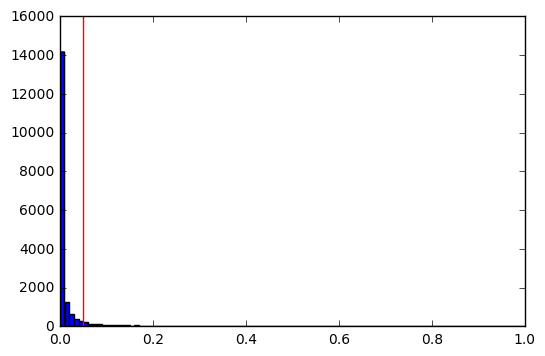

In [75]:
mnist_X,mnist_Y= next(mnist_validation_stream.get_epoch_iterator())
Z_v = sess.run(Z, feed_dict={X: mnist_X})
_ = plt.hist(Z_v.ravel(), 100)
plt.vlines(0.05, *plt.ylim(), color='r')

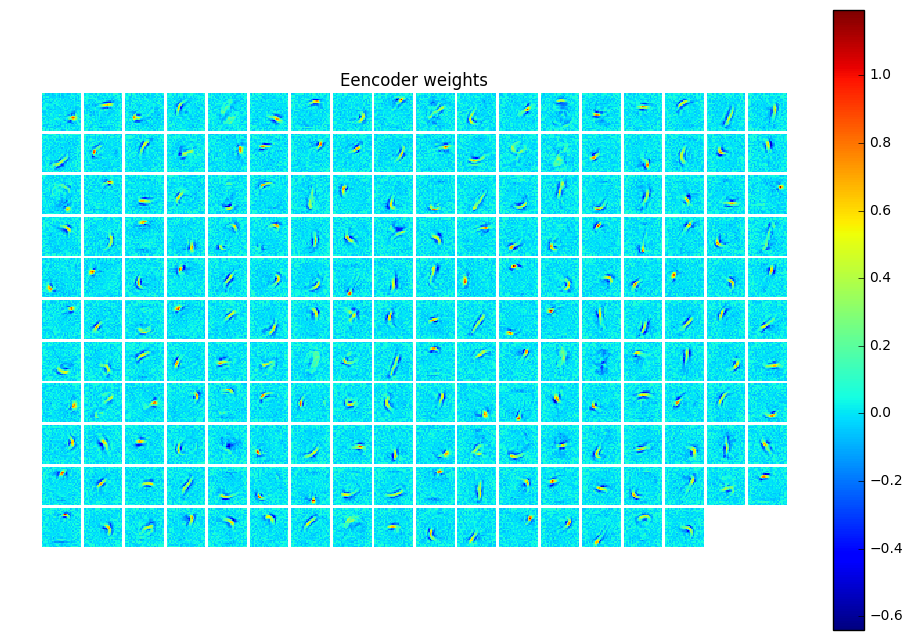

In [76]:
W0, = [v for v in tf.trainable_variables() if v.name==u'enc/affine_layer/W:0']
plt.figure(figsize=(12,8))
W0_v = sess.run(W0).T
W_as_img = np.reshape(W0_v, W0_v.shape[:1] + tuple(X.shape.as_list()[1:]))
plot_mat(W_as_img, scaleIndividual=False, colorbar=True)
plt.title('Eencoder weights')

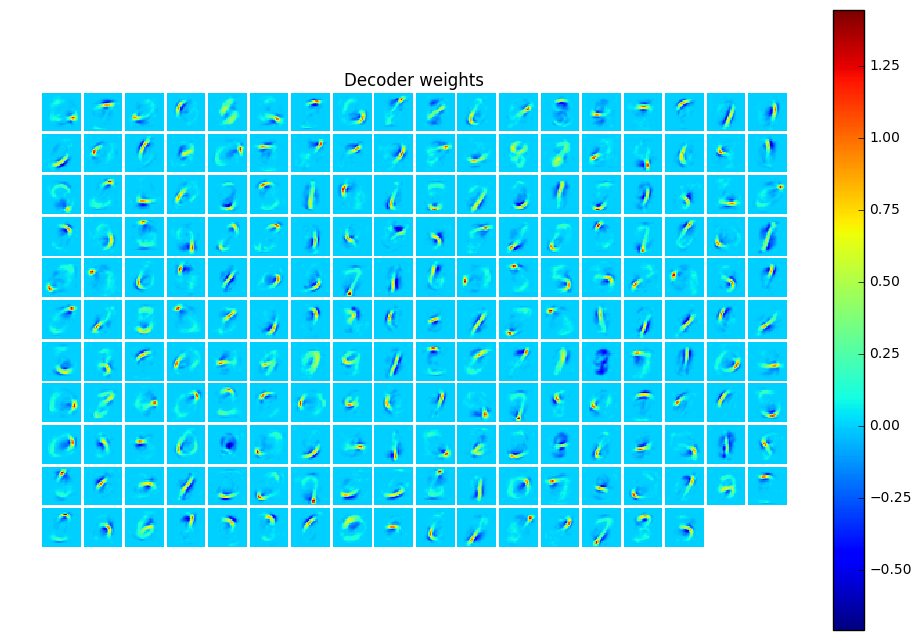

In [77]:
W1, = [v for v in tf.trainable_variables() if v.name==u'dec/affine_layer/W:0']
plt.figure(figsize=(12,8))
W1_v = sess.run(W1)
W_as_img = np.reshape(W1_v, W1_v.shape[:1] + tuple(X.shape.as_list()[1:]))
plot_mat(W_as_img, scaleIndividual=False, colorbar=True)
plt.title('Decoder weights')

# Further reading

More information on autoencoders: https://blog.keras.io/building-autoencoders-in-keras.html